### Naive Rag

In [1]:
from dotenv import load_dotenv

load_dotenv()

True

In [2]:
from langchain_teddynote import logging

logging.langsmith("edu-CH17-LangGraph-Structures")

LangSmith 추적을 시작합니다.
[프로젝트명]
edu-CH17-LangGraph-Structures


### Basic PDF Retrieval Chain 

In [3]:
from rag.pdf import PDFRetrievalChain

pdf = PDFRetrievalChain(["./data/SPRI_AI_Brief_2023년12월호_F.pdf"]).create_chain()

pdf_retriever = pdf.retriever
pdf_chain = pdf.chain

In [4]:
search_result = pdf_retriever.invoke("앤스로픽에 투자한 기업과 투자금액을 알려주세요.")
search_result

[Document(id='551401e8-60fc-47fd-b825-58794e493365', metadata={'source': './data/SPRI_AI_Brief_2023년12월호_F.pdf', 'file_path': './data/SPRI_AI_Brief_2023년12월호_F.pdf', 'page': 13, 'total_pages': 23, 'Author': 'dj', 'Creator': 'Hwp 2018 10.0.0.13462', 'Producer': 'Hancom PDF 1.3.0.542', 'CreationDate': "D:20231208132838+09'00'", 'ModDate': "D:20231208132838+09'00'", 'PDFVersion': '1.4'}, page_content='1. 정책/법제 2. 기업/산업 3. 기술/연구 4. 인력/교육\n구글, 앤스로픽에 20억 달러 투자로 생성 AI 협력 강화\nKEY Contents\nn 구글이 앤스로픽에 최대 20억 달러 투자에 합의하고 5억 달러를 우선 투자했으며, 앤스로픽은\n구글과 클라우드 서비스 사용 계약도 체결\nn 3대 클라우드 사업자인 구글, 마이크로소프트, 아마존은 차세대 AI 모델의 대표 기업인\n앤스로픽 및 오픈AI와 협력을 확대하는 추세\n£구글, 앤스로픽에 최대 20억 달러 투자 합의 및 클라우드 서비스 제공'),
 Document(id='cf2cff7b-2037-4128-ae27-ac6552288de0', metadata={'source': './data/SPRI_AI_Brief_2023년12월호_F.pdf', 'file_path': './data/SPRI_AI_Brief_2023년12월호_F.pdf', 'page': 13, 'total_pages': 23, 'Author': 'dj', 'Creator': 'Hwp 2018 10.0.0.13462', 'Producer': 'Hancom PDF 1.3.0.542', 'CreationDate': "D:20231208

In [5]:
answer = pdf_chain.invoke(
    {
        "context": search_result, 
        "question": "앤스로픽에 투자한 기업과 투자금액을 알려주세요.",
        "chat_history": []
    }
)

print(answer)

구글은 앤스로픽에 최대 20억 달러를 투자하기로 합의하였으며, 이 중 5억 달러를 우선 투자했습니다. 또한, 아마존은 앤스로픽에 최대 40억 달러의 투자 계획을 발표했습니다.

**Source**
- ./data/SPRI_AI_Brief_2023년12월호_F.pdf (page 13)


### Naive RAG -> LangGraph 

In [49]:
from typing import Annotated, TypedDict
from langgraph.graph.message import add_messages

class GraphState(TypedDict):
    question: Annotated[str, "Question"]
    context: Annotated[str, "Context"]
    answer: Annotated[str, "Answer"]
    messages: Annotated[list, add_messages]
    relevance: Annotated[str, "Relevance"]  # 관련성

In [ ]:
question = "앤스로픽에 투자한 기업과 투자금액을 알려주세요."
response = pdf_chain.invoke(
        {
            "question": question, 
            "context": pdf_retriever.invoke(question),
            "chat_history": [],# messages_to_history(state["messages"])
        }
    )
response

'구글은 앤스로픽에 최대 20억 달러를 투자하기로 합의하였으며, 이 중 5억 달러를 우선 투자했습니다. 추가로 15억 달러를 투자할 계획입니다. 또한, 아마존은 앤스로픽에 최대 40억 달러의 투자 계획을 발표했습니다.\n\n**Source**\n- ./data/SPRI_AI_Brief_2023년12월호_F.pdf (page 13)'

In [50]:
from langchain_openai import ChatOpenAI
from langchain_teddynote.evaluator import GroundednessChecker
from langchain_teddynote.messages import messages_to_history
from rag.utils import format_docs

# 문서 검색 노드 
def retrieve_document(state: GraphState) -> GraphState:
    latest_question = state["question"]
    retrieved_docs = pdf_retriever.invoke(latest_question)
    retrieved_docs = format_docs(retrieved_docs)
    
    return GraphState(context=retrieved_docs)

# 답변 생성 노드
def llm_answer(state: GraphState) -> GraphState:
    latest_question = state["question"]
    context = state["context"]
    response = pdf_chain.invoke(
        {
            "question": latest_question, 
            "context": context,
            "chat_history": messages_to_history(state["messages"])
        }
    )
    return GraphState(
        answer=response, 
        messages=[("user", latest_question), ("assistant", response)]
    )

# add 관련성 체크 노드 
def relevance_check(state: GraphState) -> GraphState:
    question_retrieval_relevant = GroundednessChecker(
        llm=ChatOpenAI(model="gpt-4o-mini", temperature=0), target="question-retrieval"
    ).create()

    # yes or no
    response = question_retrieval_relevant.invoke(
        {"question": state["question"], "context": state["context"]}
    )
    
    print("==== [RELEVANCE CHECK] ====")
    print(response.score)
    
    return GraphState(relevance=response.score)

def is_relevant(state: GraphState) -> GraphState:
    if state["relevance"] == "yes":
        return "relevant"
    else:
        return "not relevant"

In [52]:
from langgraph.graph import END, StateGraph
from langgraph.checkpoint.memory import MemorySaver

# 그래프 정의
workflow = StateGraph(GraphState)

# 노드 추가
workflow.add_node("retrieve", retrieve_document)
workflow.add_node("relevance_check", relevance_check)
workflow.add_node("llm_answer", llm_answer)

# 엣지 추가
workflow.add_edge("retrieve", "relevance_check")  # 검색 -> 관련성 체크
workflow.add_conditional_edges(
    "relevance_check",
    is_relevant,
    {
        "relevant": "llm_answer",
        "not relevant": "retrieve",
    },
)
workflow.add_edge("llm_answer", END)
workflow.set_entry_point("retrieve")

memory = MemorySaver()
app = workflow.compile(checkpointer=memory)

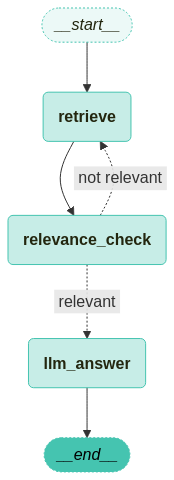

In [53]:
from langchain_teddynote.graphs import visualize_graph

visualize_graph(app)

In [54]:
from langchain_core.runnables import RunnableConfig
from langchain_teddynote.messages import invoke_graph, stream_graph, random_uuid

# config 설정(재귀 최대 횟수, thread_id)
config = RunnableConfig(recursion_limit=20, configurable={"thread_id": random_uuid()})

# 질문 입력
inputs = GraphState(question="앤스로픽에 투자한 기업과 투자금액을 알려주세요.")

# 그래프 실행
invoke_graph(app, inputs, config)


🔄 Node: retrieve 🔄
- - - - - - - - - - - - - - - - - - - - - - - - - 
context:
<document><content>1. 정책/법제 2. 기업/산업 3. 기술/연구 4. 인력/교육
구글, 앤스로픽에 20억 달러 투자로 생성 AI 협력 강화
KEY Contents
n 구글이 앤스로픽에 최대 20억 달러 투자에 합의하고 5억 달러를 우선 투자했으며, 앤스로픽은
구글과 클라우드 서비스 사용 계약도 체결
n 3대 클라우드 사업자인 구글, 마이크로소프트, 아마존은 차세대 AI 모델의 대표 기업인
앤스로픽 및 오픈AI와 협력을 확대하는 추세
£구글, 앤스로픽에 최대 20억 달러 투자 합의 및 클라우드 서비스 제공</content><source>./data/SPRI_AI_Brief_2023년12월호_F.pdf</source><page>14</page></document>
<document><content>£구글, 앤스로픽에 최대 20억 달러 투자 합의 및 클라우드 서비스 제공
n 구글이 2023년 10월 27일 앤스로픽에 최대 20억 달러를 투자하기로 합의했으며, 이 중 5억
달러를 우선 투자하고 향후 15억 달러를 추가로 투자할 방침
∙ 구글은 2023년 2월 앤스로픽에 이미 5억 5,000만 달러를 투자한 바 있으며, 아마존도 지난 9월
앤스로픽에 최대 40억 달러의 투자 계획을 공개
∙ 한편, 2023년 11월 8일 블룸버그 보도에 따르면 앤스로픽은 구글의 클라우드 서비스 사용을 위해
4년간 30억 달러 규모의 계약을 체결</content><source>./data/SPRI_AI_Brief_2023년12월호_F.pdf</source><page>14</page></document>
<document><content>4년간 30억 달러 규모의 계약을 체결
∙ 오픈AI 창업자 그룹의 일원이었던 다리오(Dario Amodei)와 다니엘라 아모데이(Daniela Amodei)
남매가 2021년 설립한 앤스로픽은 챗G

In [55]:
# 특정 노드만 출력하여 확인 가능  
# invoke_graph(app, inputs, config, ["llm_answer"])
invoke_graph(app, inputs, config, ["relevance_check", "llm_answer"])

==== [RELEVANCE CHECK] ====
yes

🔄 Node: relevance_check 🔄
- - - - - - - - - - - - - - - - - - - - - - - - - 
relevance:
yes

🔄 Node: llm_answer 🔄
- - - - - - - - - - - - - - - - - - - - - - - - - 
answer:
구글은 앤스로픽에 최대 20억 달러를 투자하기로 합의하고, 이 중 5억 달러를 우선 투자했습니다. 아마존은 앤스로픽에 최대 40억 달러의 투자 계획을 발표했습니다.

**Source**
- ./data/SPRI_AI_Brief_2023년12월호_F.pdf (page 14)
('user', '앤스로픽에 투자한 기업과 투자금액을 알려주세요.')
('assistant', '구글은 앤스로픽에 최대 20억 달러를 투자하기로 합의하고, 이 중 5억 달러를 우선 투자했습니다. 아마존은 앤스로픽에 최대 40억 달러의 투자 계획을 발표했습니다.\n\n**Source**\n- ./data/SPRI_AI_Brief_2023년12월호_F.pdf (page 14)')


In [56]:
stream_graph(app, inputs, config)


🔄 Node: relevance_check 🔄
- - - - - - - - - - - - - - - - - - - - - - - - - 
{"score":"yes"}==== [RELEVANCE CHECK] ====
yes

🔄 Node: llm_answer 🔄
- - - - - - - - - - - - - - - - - - - - - - - - - 
구글은 앤스로픽에 최대 20억 달러를 투자하기로 합의하고, 이 중 5억 달러를 우선 투자했습니다. 아마존은 앤스로픽에 최대 40억 달러의 투자 계획을 발표했습니다.

**Source**
- ./data/SPRI_AI_Brief_2023년12월호_F.pdf (page 14)

In [57]:
outputs = app.get_state(config).values 

# print(outputs)
print(f'Question: {outputs["question"]}')
print("===" * 20)
print(f'Answer:\n{outputs["answer"]}')

Question: 앤스로픽에 투자한 기업과 투자금액을 알려주세요.
Answer:
구글은 앤스로픽에 최대 20억 달러를 투자하기로 합의하고, 이 중 5억 달러를 우선 투자했습니다. 아마존은 앤스로픽에 최대 40억 달러의 투자 계획을 발표했습니다.

**Source**
- ./data/SPRI_AI_Brief_2023년12월호_F.pdf (page 14)


In [58]:
print(outputs["relevance"])

yes


In [59]:
from langgraph.errors import GraphRecursionError
from langchain_core.runnables import RunnableConfig

config = RunnableConfig(recursion_limit=10, configurable={"thread_id": random_uuid()})

inputs = GraphState(question="테디노트의 랭체인 튜토리얼에 대한 정보를 알려주세요.")

try:
    stream_graph(app, inputs, config, ["retrieve", "relevance_check", "llm_answer"])
except GraphRecursionError as recursion_error:
    print(f"GraphRecursionError: {recursion_error}")


🔄 Node: relevance_check 🔄
- - - - - - - - - - - - - - - - - - - - - - - - - 
{"score":"no"}==== [RELEVANCE CHECK] ====
no
{"score":"no"}==== [RELEVANCE CHECK] ====
no
{"score":"no"}==== [RELEVANCE CHECK] ====
no
{"score":"no"}==== [RELEVANCE CHECK] ====
no
{"score":"no"}==== [RELEVANCE CHECK] ====
no
GraphRecursionError: Recursion limit of 10 reached without hitting a stop condition. You can increase the limit by setting the `recursion_limit` config key.
For troubleshooting, visit: https://python.langchain.com/docs/troubleshooting/errors/GRAPH_RECURSION_LIMIT
